In [1]:
# Import the necessary components
from epydemix import EpiModel
from epydemix.visualization import plot_quantiles, plot_trajectories

In [2]:
# Defining a basic SIR model
sir_model = EpiModel(
    name='SIR Model',
    compartments=['S', 'I', 'R'],  # Susceptible, Infected, Recovered
)

# Defining the transitions
sir_model.add_transition(source='S', target='I', params=(0.3, "I"), kind='mediated')
sir_model.add_transition(source='I', target='R', params=0.1, kind='spontaneous')

print(sir_model)

EpiModel(name='SIR Model')
Compartments: 3
  S, I, R
Transitions: 2
  Transitions between compartments:
    S -> I, params: (0.3, 'I') (kind: mediated)
    I -> R, params: 0.1 (kind: spontaneous)
Parameters: 0
  No parameters defined
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



In [ ]:
def run(): 
    sir_results = sir_model.run_simulations(
        start_date="2024-01-01",
        end_date="2024-04-10")

In [ ]:
%timeit run()

In [3]:
from scipy import stats 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from epydemix import load_predefined_model, simulate
from epydemix.visualization import plot_distance_distribution, plot_quantiles, plot_posterior_distribution, plot_posterior_distribution_2d
from epydemix.calibration import ABCSampler, rmse 
from epydemix.utils import compute_simulation_dates

import seaborn as sns   
colors = sns.color_palette("Dark2")

Text(0, 0.5, 'New Infections')

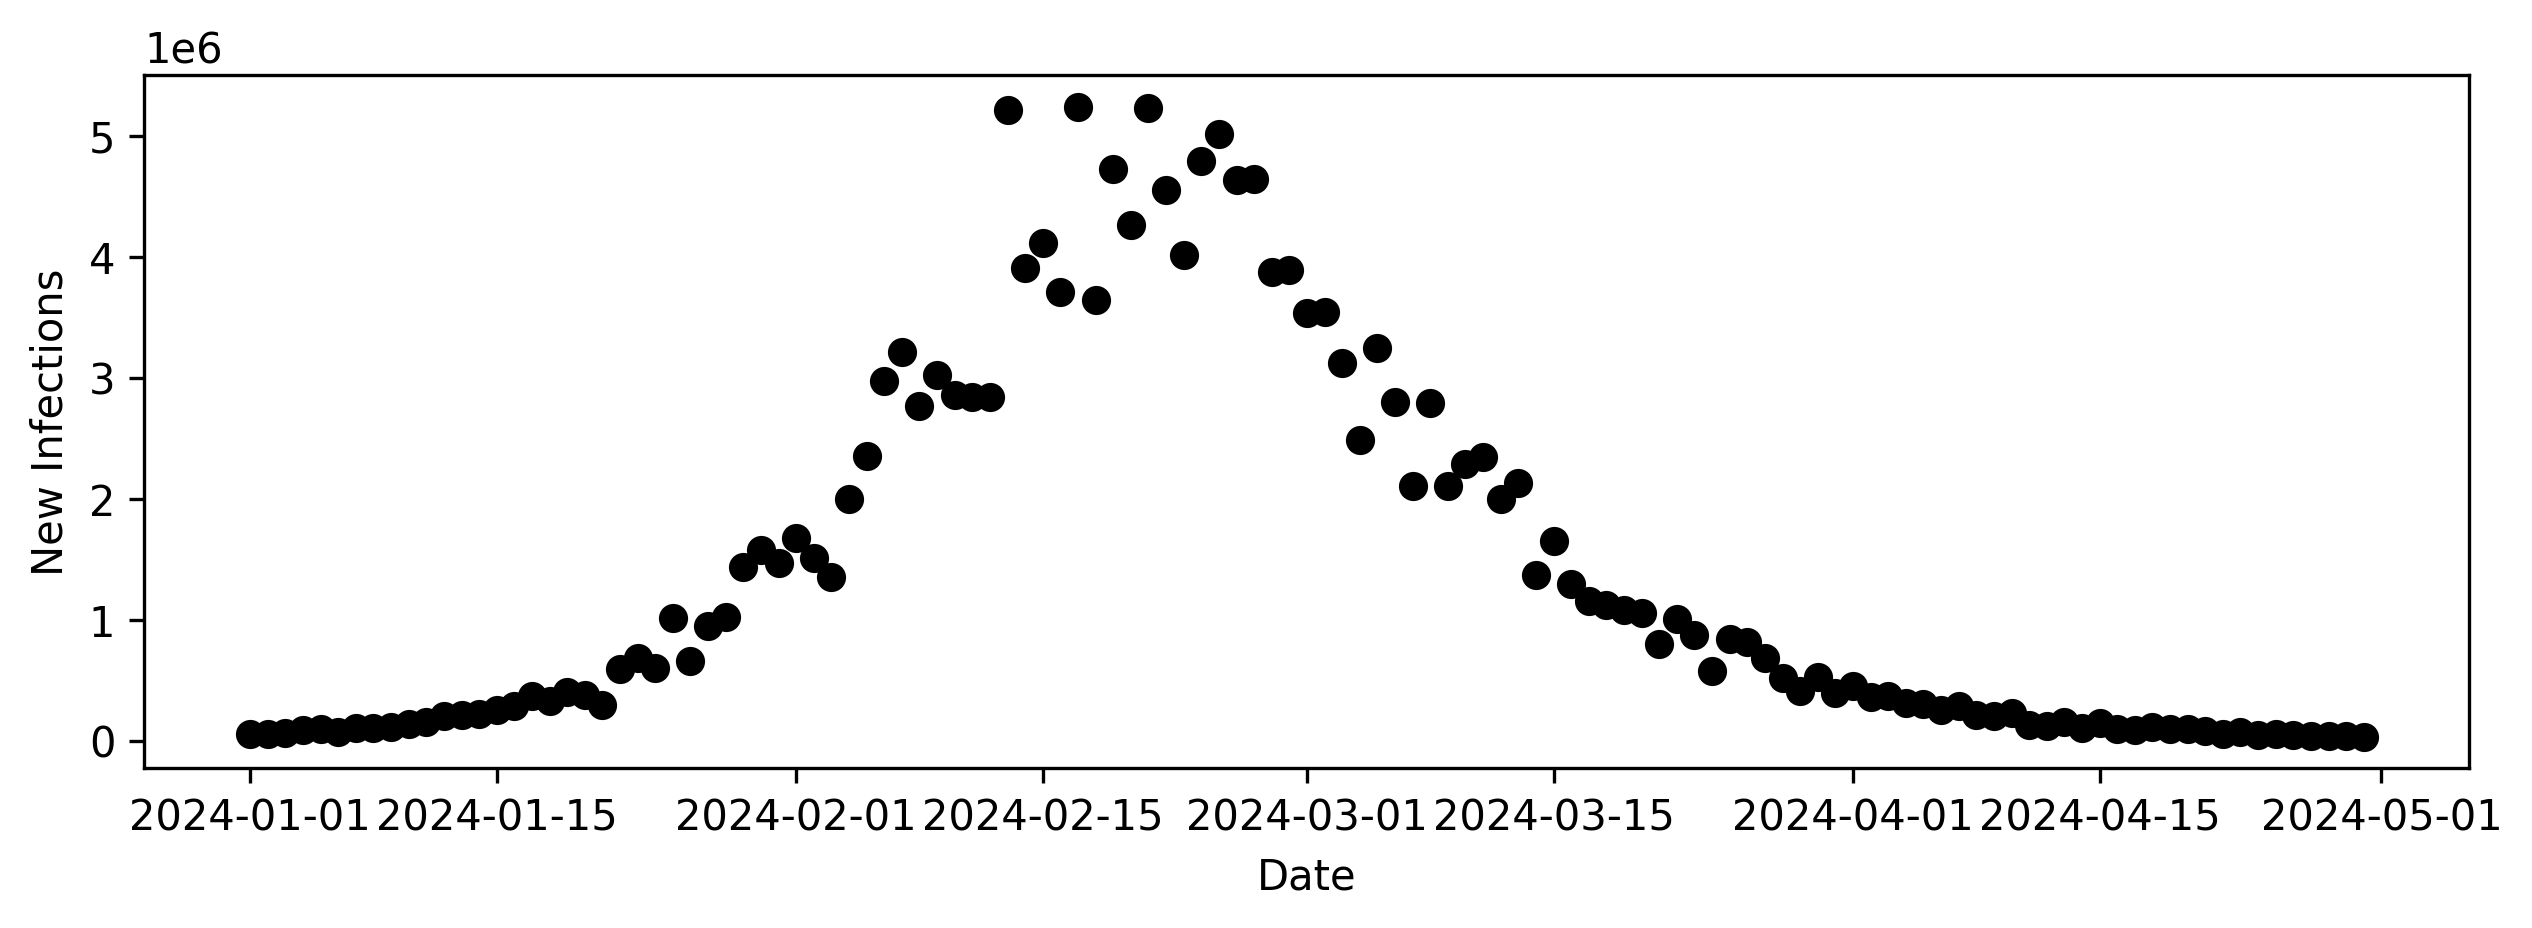

In [4]:
data = pd.read_csv('./tutorials/data/incidence_data.csv')
data["date"] = pd.to_datetime(data["date"])

fig, ax = plt.subplots(dpi=300, figsize=(10, 3))
plt.plot(data["date"], data["data"], label="I", color="k", linestyle="None", marker="o")
plt.xlabel("Date")
plt.ylabel("New Infections")

In [5]:
model = load_predefined_model("SIR")
model.import_epydemix_population(population_name="Indonesia")
print(model)

EpiModel(name='EpiModel')
Compartments: 3
  Susceptible, Infected, Recovered
Transitions: 2
  Transitions between compartments:
    Susceptible -> Infected, params: ('transmission_rate', 'Infected') (kind: mediated)
    Infected -> Recovered, params: recovery_rate (kind: spontaneous)
Parameters: 2
  Model parameters:
    transmission_rate: 0.3
    recovery_rate: 0.1
Population: Indonesia
  Population size: 282353643 individuals
  Demographic groups: 5
    0-4, 5-19, 20-49, 50-64, 65+



In [6]:
# initial conditions (we assume fully S population except for 0.05% infected individual across age groups)
initial_conditions = {"Susceptible": model.population.Nk - (model.population.Nk * 0.05 / 100).astype(int), 
                      "Infected": (model.population.Nk * 0.05/100).astype(int),
                      "Recovered": np.zeros(len(model.population.Nk))}

# simulation dates 
simulation_dates = compute_simulation_dates(start_date=data.date.values[0], end_date=data.date.values[-1])

# simulation parameters
parameters = {"initial_conditions_dict": initial_conditions,
              "epimodel": model, 
              "start_date": data.date.values[0],
              "end_date": data.date.values[-1]
              }

In [7]:
priors = {"transmission_rate": stats.uniform(0.010, 0.020), 
          "recovery_rate": stats.uniform(0.15, 0.1)}

In [8]:
def simulate_wrapper(parameters): 
    results = simulate(**parameters)
    return {"data": results.transitions["Susceptible_to_Infected_total"]}

# initialize the ABCSampler object
abc_sampler = ABCSampler(simulation_function=simulate_wrapper, 
                         priors=priors, 
                         parameters=parameters, 
                         observed_data=data["data"].values, 
                         distance_function=rmse)

In [9]:
results_abc_smc = abc_sampler.calibrate(strategy="smc", 
                    num_particles=100, 
                    num_generations=5)

Starting ABC-SMC with 100 particles and 5 generations

Generation 1/5 (epsilon: inf)
	Accepted 100/100 (acceptance rate: 100.00%)
	Elapsed time: 00:00:04

Generation 2/5 (epsilon: 1998350.574085)
	Accepted 100/191 (acceptance rate: 52.36%)
	Elapsed time: 00:00:09

Generation 3/5 (epsilon: 1210518.291460)
	Accepted 100/300 (acceptance rate: 33.33%)
	Elapsed time: 00:00:13

Generation 4/5 (epsilon: 704532.936875)
	Accepted 100/387 (acceptance rate: 25.84%)
	Elapsed time: 00:00:16

Generation 5/5 (epsilon: 483782.461911)
	Accepted 100/607 (acceptance rate: 16.47%)
	Elapsed time: 00:00:25


In [10]:
# create projection parameters
projection_parameters = parameters.copy()
projection_parameters["end_date"] = "2024-06-10"

# run projections
results_abc_smc = abc_sampler.run_projections(projection_parameters)

<Axes: >

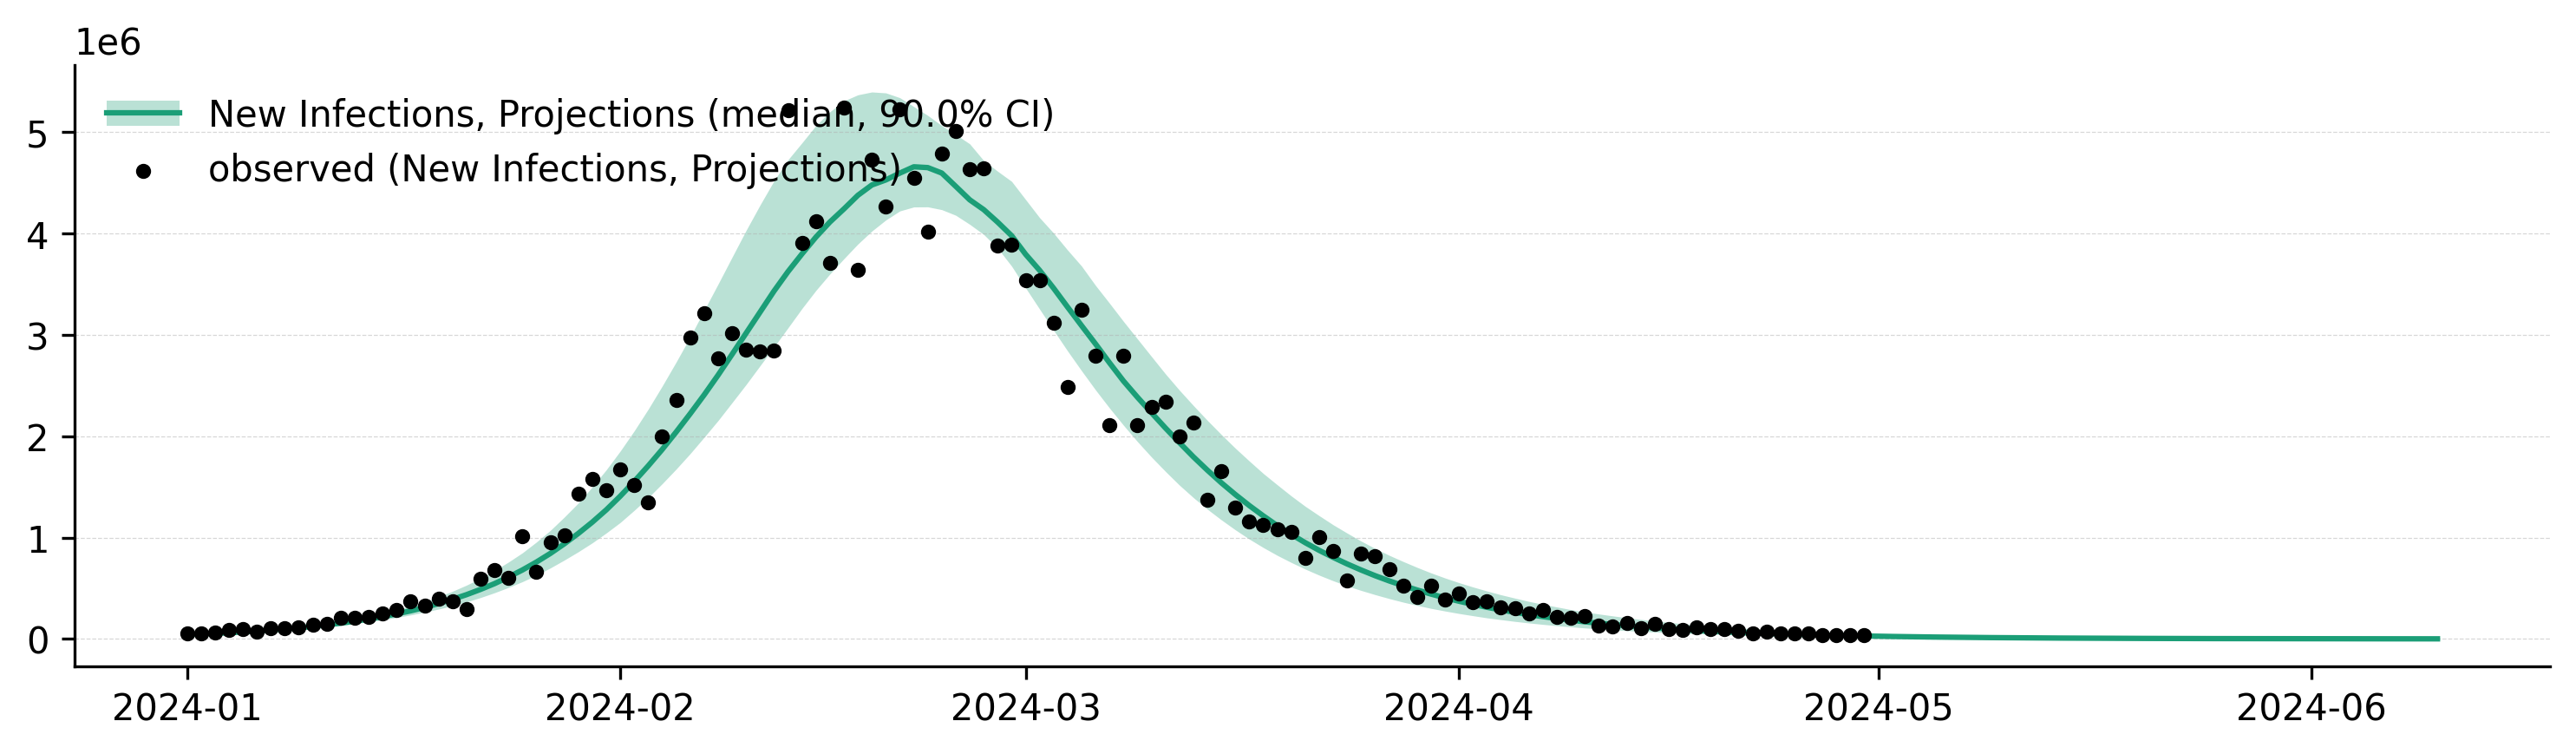

In [11]:
# plot the projections
from epydemix.utils import compute_simulation_dates
simulation_dates_projection = compute_simulation_dates(start_date=data.date.values[0], end_date="2024-06-10")
df_quantiles_projections = results_abc_smc.get_projection_quantiles(simulation_dates_projection)

fig, ax = plt.subplots(dpi=300, figsize=(10, 3))
plot_quantiles(df_quantiles_projections, columns="data", data=data, ax=ax, colors=colors[0], show_legend=True, show_data=True, labels=["New Infections, Projections"])

In [21]:
# initial conditions (we assume fully S population except for 0.05% infected individual across age groups)
initial_conditions = {"Susceptible": model.population.Nk - (model.population.Nk * 0.05 / 100).astype(int), 
                      "Infected": (model.population.Nk * 0.05/100).astype(int),
                      "Recovered": np.zeros(len(model.population.Nk))}
initial_conditions

{'Susceptible': array([ 22273569,  70831354, 125352951,  43535370,  20219225]),
 'Infected': array([11142, 35433, 62707, 21778, 10114]),
 'Recovered': array([0., 0., 0., 0., 0.])}

In [24]:
def get_initial_conditions_dict(Nk, perc_dict): 
    """
    Helper function to get initial conditions dictionary from percentage dictionary.

    Args:
        perc_dict (dict): Dictionary with percentage of population for each compartment

    Returns:
        dict: Initial conditions dictionary
    """
    return {key: (Nk * perc_dict[key] / 100).astype(int) for key in perc_dict.keys()}


In [25]:
get_initial_conditions_dict(Nk=model.population.Nk, perc_dict={"Susceptible": 99.95, "Infected": 0.05, "Recovered": 0})

{'Susceptible': array([ 22273568,  70831353, 125352950,  43535369,  20219224]),
 'Infected': array([11142, 35433, 62707, 21778, 10114]),
 'Recovered': array([0, 0, 0, 0, 0])}

In [26]:
get_initial_conditions_dict(Nk=model.population.Nk, perc_dict={"Susceptible": [99.95, 0, 0, 0, 0], "Infected": [0.05, 99.95, 99.95, 99.95, 99.95], "Recovered": 0})

{'Susceptible': array([22273568,        0,        0,        0,        0]),
 'Infected': array([    11142,  70831353, 125352950,  43535369,  20219224]),
 'Recovered': array([0, 0, 0, 0, 0])}

In [ ]:
import multiprocess as mp
from epydemix.model import load_predefined_model
import numpy as np

model = load_predefined_model("SIR")


In [12]:
def run_simulations(args):
    results = model.run_simulations(Nsim=args[0], rng=args[1])
    return results

Nsim = 100
nprocs = 16
args = []
for i in range(nprocs):
    args.append((Nsim//nprocs, np.random.default_rng()))

with mp.Pool() as pool:
    result = pool.map(run_simulations, args)